In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('hpq.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close'])
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


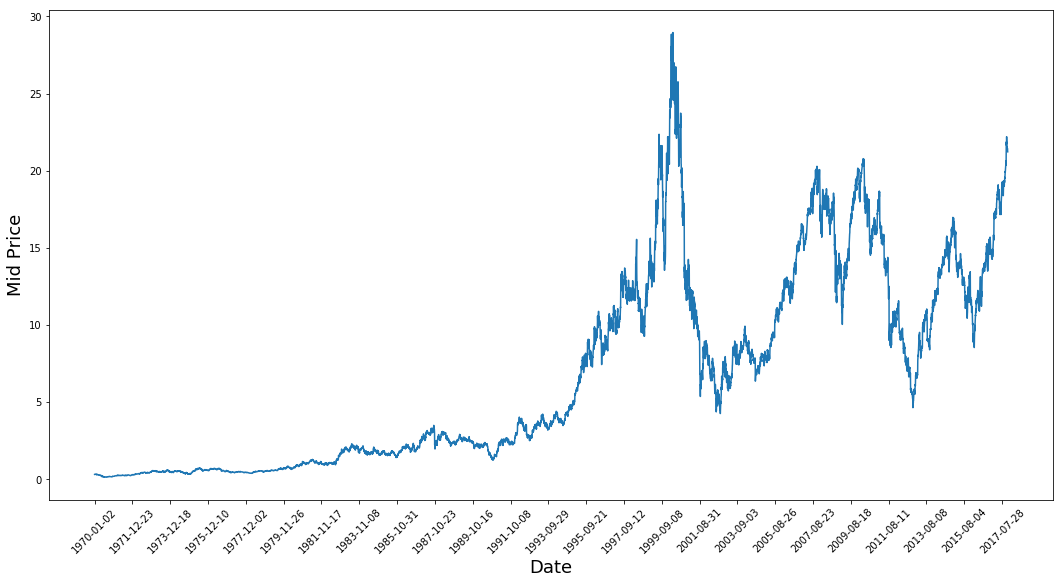

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [4]:
open_prices = df.loc[:,'Open'].as_matrix()
close_prices = df.loc[:,'Close'].as_matrix()
#mid_prices = (high_prices+low_prices)/2.0

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [5]:
train_data_open = open_prices[:11000]
test_data_open = open_prices[11000:]
train_data_close = close_prices[:11000]
test_data_close = close_prices[11000:]

In [6]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
train_data_open = train_data_open.reshape(-1,1)
test_data_open = test_data_open.reshape(-1,1)
train_data_close = train_data_close.reshape(-1,1)
test_data_close = test_data_close.reshape(-1,1)

In [7]:
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler1.fit(train_data_open[di:di+smoothing_window_size,:])
    train_data_open[di:di+smoothing_window_size,:] = scaler1.transform(train_data_open[di:di+smoothing_window_size,:])
    scaler2.fit(train_data_close[di:di+smoothing_window_size,:])
    train_data_close[di:di+smoothing_window_size,:] = scaler2.transform(train_data_close[di:di+smoothing_window_size,:])    

# You normalize the last bit of remaining data
scaler1.fit(train_data_open[di+smoothing_window_size:,:])
train_data_open[di+smoothing_window_size:,:] = scaler1.transform(train_data_open[di+smoothing_window_size:,:])
scaler2.fit(train_data_close[di+smoothing_window_size:,:])
train_data_close[di+smoothing_window_size:,:] = scaler2.transform(train_data_close[di+smoothing_window_size:,:])

In [8]:
train_data_open = train_data_open.reshape(-1)
train_data_close = train_data_close.reshape(-1)

# Normalize test data
test_data_open = scaler1.transform(test_data_open).reshape(-1)
test_data_close = scaler2.transform(test_data_close).reshape(-1)

In [9]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA1 = 0.0
EMA2 = 0.0
gamma = 0.1
for ti in range(11000):
    EMA1 = gamma*train_data_open[ti] + (1-gamma)*EMA1
    train_data_open[ti] = EMA1
    EMA2 = gamma*train_data_close[ti] + (1-gamma)*EMA2
    train_data_close[ti] = EMA2

# Used for visualization and test purposes
all_mid_data_open = np.concatenate([train_data_open,test_data_open],axis=0)
all_mid_data_close = np.concatenate([train_data_close,test_data_close],axis=0)

In [10]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


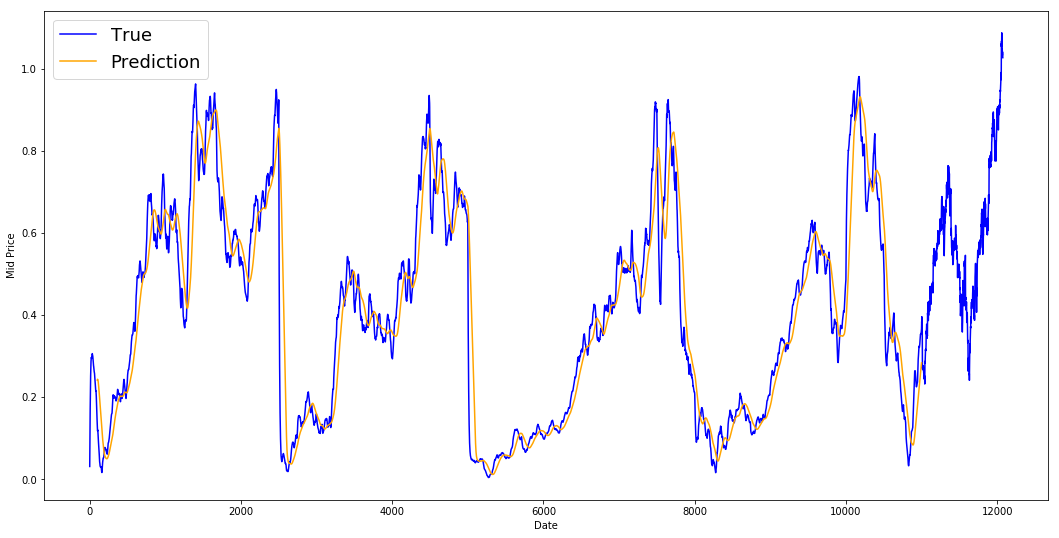

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [49]:
window_size = 100
N = all_mid_data_open.size

run_avg_predictions_open = []
run_avg_x_open = []
run_avg_predictions_close = []
run_avg_x_close = []

mse_errors_open = []
mse_errors_close = []

running_mean_open = 0.0
run_avg_predictions_open.append(running_mean_open)
running_mean_close = 0.0
run_avg_predictions_close.append(running_mean_close)

decay = 0.5

for pred_idx in range(1,N):

    running_mean_open = running_mean_open*decay + (1.0-decay)*all_mid_data_open[pred_idx-1]
    run_avg_predictions_open.append(running_mean_open)
    mse_errors_open.append((run_avg_predictions_open[-1]-all_mid_data_open[pred_idx])**2)
    #run_avg_x_open.append(date)

    running_mean_close = running_mean_close*decay + (1.0-decay)*all_mid_data_close[pred_idx-1]
    run_avg_predictions_close.append(running_mean_close)
    mse_errors_close.append((run_avg_predictions_close[-1]-all_mid_data_close[pred_idx])**2)
    #run_avg_x_close.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors_open)))
print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors_close)))

MSE error for EMA averaging: 0.00004
MSE error for EMA averaging: 0.00004


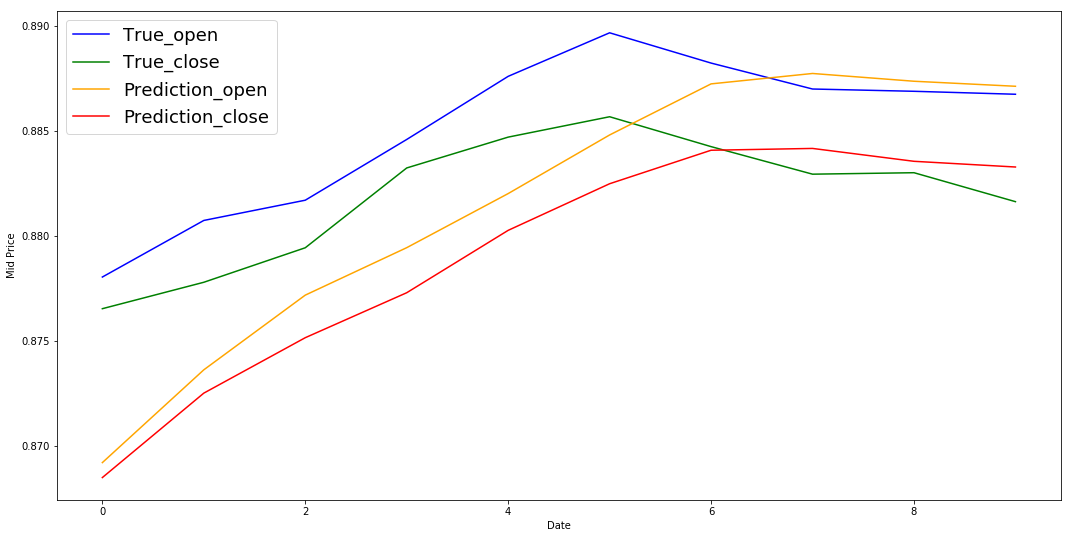

In [50]:
plt.figure(figsize = (18,9))
plt.plot(range(10),all_mid_data_open[-2010:-2000],color='b',label='True_open')
plt.plot(range(10),all_mid_data_close[-2010:-2000],color='green',label='True_close')
plt.plot(range(10),run_avg_predictions_open[-2010:-2000],color='orange', label='Prediction_open')
plt.plot(range(10),run_avg_predictions_close[-2010:-2000],color='red', label='Prediction_close')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [32]:
np.array([all_mid_data_open[-10:],run_avg_predictions_open[-10:]])

array([[ 1.04486222,  1.04238365,  1.05291759,  1.03928543,  1.04672115,
         1.04486222,  1.04486222,  1.03680685,  1.03246934,  1.03123006],
       [ 1.06159303,  1.05322763,  1.04780564,  1.05036161,  1.04482352,
         1.04577234,  1.04531728,  1.04508975,  1.0409483 ,  1.03670882]])

In [ ]:
run_avg_predictions_open[-10:]